In [75]:
import requests
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [76]:
# variant info
gene_name = input("Enter variant name (e.g., BRCA1): ")
variant_str = input("Enter variant string (e.g., c.240A>G): ")

In [67]:

# def get_chromosome_from_ensembl(gene_symbol):
#     """Query Ensembl REST API for chromosome location."""
#     # ensembl gene ID from symbol
#     url = f"https://rest.ensembl.org/xrefs/symbol/homo_sapiens/{gene_symbol}?content-type=application/json"
#     response = requests.get(url)
#     if not response.ok or not response.json():
#         return None
    
#     gene_id = response.json()[0]["id"]

#     # look up gene details
#     lookup_url = f"https://rest.ensembl.org/lookup/id/{gene_id}?content-type=application/json"
#     lookup_response = requests.get(lookup_url)
#     if not lookup_response.ok or not lookup_response.json():
#         return None
    
#     chrom = lookup_response.json().get("seq_region_name")
#     return chrom


def get_chromosome_from_ensembl(gene_symbol):
    """Query Ensembl REST API for chromosome location and return:
       chromosome number, Ensembl gene ID, and variant start position.
    """
    # Step 1: Get Ensembl gene ID from gene symbol
    url = f"https://rest.ensembl.org/xrefs/symbol/homo_sapiens/{gene_symbol}?content-type=application/json"
    response = requests.get(url)
    if not response.ok or not response.json():
        return None, None, None
    
    gene_id = response.json()[0]["id"]

    # Step 2: Get chromosome and start position
    lookup_url = f"https://rest.ensembl.org/lookup/id/{gene_id}?content-type=application/json"
    lookup_response = requests.get(lookup_url)
    if not lookup_response.ok or not lookup_response.json():
        return None, None, None
    
    chrom = lookup_response.json().get("seq_region_name")
    start_pos = lookup_response.json().get("start")

    return chrom, gene_id, start_pos


In [68]:
# gene_name = input("Enter gene name (e.g., NFIX): ")
#og below
# chromosome_num = get_chromosome_from_ensembl(gene_name)

#new
chromosome_num, ensembl_id, variant_start = get_chromosome_from_ensembl(gene_name)
#new
if chromosome_num:
    print(f"{gene_name} is on chromosome {chromosome_num}")

    
    img = Image.open("8bitChrom.png")

    # chrom dimensions
    chrom_width = 45
    chrom_height = 105
    left_margin = 44
    top_margin = 43
    horizontal_spacing = 30
    vertical_spacing = 45
    cols_per_row = 8

    # gen. coordinates
    chrom_coords = {}
    chrom_number = 1
    for row in range(3):
        y1 = top_margin + row * (chrom_height + vertical_spacing)
        y2 = y1 + chrom_height
        for col in range(cols_per_row):
            if chrom_number > 23:
                break
            x1 = left_margin + col * (chrom_width + horizontal_spacing)
            x2 = x1 + chrom_width
            chrom_coords[str(chrom_number)] = (x1, y1, x2, y2)
            chrom_number += 1

    #da box!
    if str(chromosome_num) in chrom_coords:
        draw = ImageDraw.Draw(img)
        draw.rectangle(chrom_coords[str(chromosome_num)], outline="red", width=3)

        import io, base64, re
        from IPython.display import HTML, display

        # Convert initial chromosome set image to base64
        buffer = io.BytesIO()
        img.save(buffer, format="PNG")
        chromosome_base64 = base64.b64encode(buffer.getvalue()).decode()

        # Step 3 image (p/q arm labeled chromosome)
        with open("p arm q arm labeled.PNG", "rb") as f:
            pq_base64 = base64.b64encode(f.read()).decode()

        # Get variant position + chromosome length
        ensembl_url = f"https://rest.ensembl.org/lookup/id/{ensembl_id}?expand=1"
        headers = {"Content-Type": "application/json"}
        response = requests.get(ensembl_url, headers=headers).json()
        chromosome_length = response["seq_region_length"]
        midpoint = chromosome_length / 2
        arm = "p" if variant_start < midpoint else "q"

        # Step 4: Correct zoomed arm image
        if arm == "p":
            with open("Just p arm.PNG", "rb") as f:
                arm_base64 = base64.b64encode(f.read()).decode()
            with open("dna p arm.jpg", "rb") as f:
                dna_arm_base64 = base64.b64encode(f.read()).decode()
        else:
            with open("Just q arm.PNG", "rb") as f:
                arm_base64 = base64.b64encode(f.read()).decode()
            with open("dna q arm.jpg", "rb") as f:
                dna_arm_base64 = base64.b64encode(f.read()).decode()

        # Step 5: Mutation type image
        mutation_images = {
            "duplication": "Duplication.png",
            "frameshift-del": "Frameshift-del.png",
            "frameshift-ins": "Frameshift-ins.png",
            "nonsense": "Nonsense.png",
            "missense": "Missense.png"
        }

        def classify_mutation(mutation_str):
            mut = mutation_str.strip().lower()
            if "dup" in mut:
                return "duplication"
            if "fs" in mut or "frameshift" in mut:
                return "frameshift-ins" if "ins" in mut else "frameshift-del"
            if re.search(r"del", mut) and not "fs" in mut:
                return "frameshift-del"
            if re.search(r"ins", mut) and not "fs" in mut:
                return "frameshift-ins"
            if "*" in mut or "ter" in mut or re.search(r"[a-z]{3}\d+x", mut):
                return "nonsense"
            if ">" in mut or re.search(r"[a-z]{3}\d+[a-z]{3}", mut):
                return "missense"
            return None

        mutation_type = classify_mutation(variant_str)
        if mutation_type in mutation_images:
            with open(mutation_images[mutation_type], "rb") as f:
                mutation_base64 = base64.b64encode(f.read()).decode()
        else:
            mutation_base64 = chromosome_base64

        # HTML & JS for click sequence
        html_code = f"""
        <div id="image-container">
            <img id="main-image" src="data:image/png;base64,{chromosome_base64}" width="800" style="cursor:pointer;">
        </div>
        <script>
            let step = 0;
            document.getElementById('main-image').onclick = function() {{
                step++;
                if (step === 1) {{
                    this.src = "data:image/png;base64,{pq_base64}";
                }} else if (step === 2) {{
                    this.src = "data:image/png;base64,{arm_base64}";
                }} else if (step === 3) {{
                    this.src = "data:image/png;base64,{dna_arm_base64}";
                }} else if (step === 4) {{
                    this.src = "data:image/png;base64,{mutation_base64}";
                }}
            }};
        </script>
        """
        display(HTML(html_code))
    #     draw = ImageDraw.Draw(img)
    #     draw.rectangle(chrom_coords[str(chromosome_num)], outline="red", width=3)
    #     import io, base64, re
    #     from IPython.display import HTML, display

    #     # png pics i made into base64
    #     buffer = io.BytesIO()
    #     img.save(buffer, format="PNG")
    #     chromosome_base64 = base64.b64encode(buffer.getvalue()).decode()

        
    #     mutation_images = {
    #         "duplication": "Duplication.png",
    #         "frameshift-del": "Frameshift-del.png",
    #         "frameshift-ins": "Frameshift-ins.png",
    #         "nonsense": "Nonsense.png",
    #         "missense": "Missense.png"
    #     }

    #     # mutation type
    #     def classify_mutation(mutation_str):
    #         mut = mutation_str.strip().lower()
    #         if "dup" in mut:
    #             return "duplication"
    #         if "fs" in mut or "frameshift" in mut:
    #             return "frameshift-ins" if "ins" in mut else "frameshift-del"
    #         if re.search(r"del", mut) and not "fs" in mut:
    #             return "frameshift-del"
    #         if re.search(r"ins", mut) and not "fs" in mut:
    #             return "frameshift-ins"
    #         if "*" in mut or "ter" in mut or re.search(r"[a-z]{3}\d+x", mut):
    #             return "nonsense"
    #         if ">" in mut or re.search(r"[a-z]{3}\d+[a-z]{3}", mut):
    #             return "missense"
    #         return None

    #     #
    #     # variant_str = input("Enter mutation (e.g., c.240A>G): ")
    #     mutation_type = classify_mutation(variant_str)

    #     # base64 conversion
    #     if mutation_type in mutation_images:
    #         with open(mutation_images[mutation_type], "rb") as f:
    #             mutation_base64 = base64.b64encode(f.read()).decode()
    #     else:
    #         mutation_base64 = chromosome_base64

    #     # HTML+JS clickable image
    #     html_code = f"""
    #     <div id="image-container">
    #     <img id="main-image" src="data:image/png;base64,{chromosome_base64}" width="800" style="cursor:pointer;">
    #     </div>
    #     <script>
    #     document.getElementById('main-image').onclick = function() {{
    #         this.src = "data:image/png;base64,{mutation_base64}";
    #     }};
    #     </script>
    #     """
    #     display(HTML(html_code))  
             
            
    #             # plt.imshow(img)
    #             # plt.axis("off")
    #             # plt.show()

    # else:
    #     print("Gene not found in Ensembl. Did you mistype?")
    

BRCA1 is on chromosome 17


KeyError: 'seq_region_length'

what is pytest? research mayb can use later


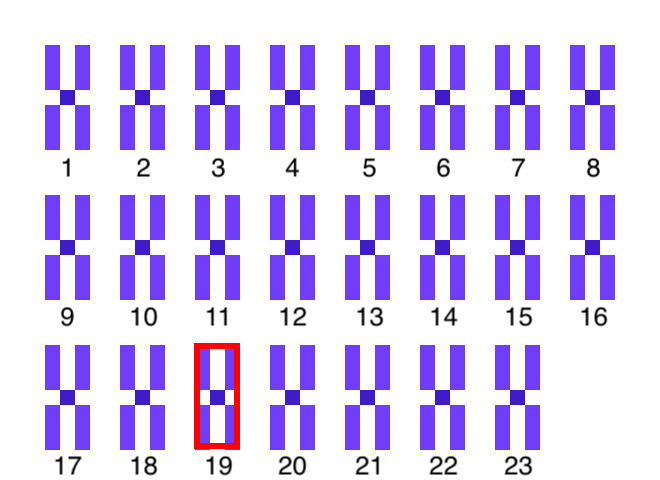
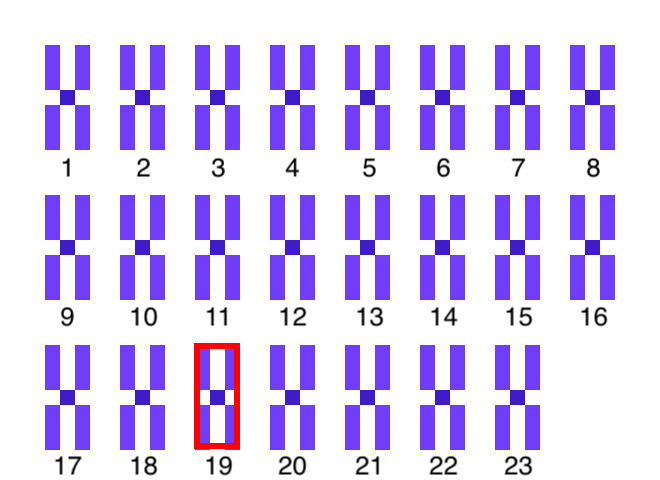
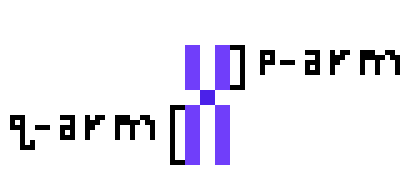
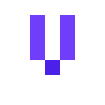
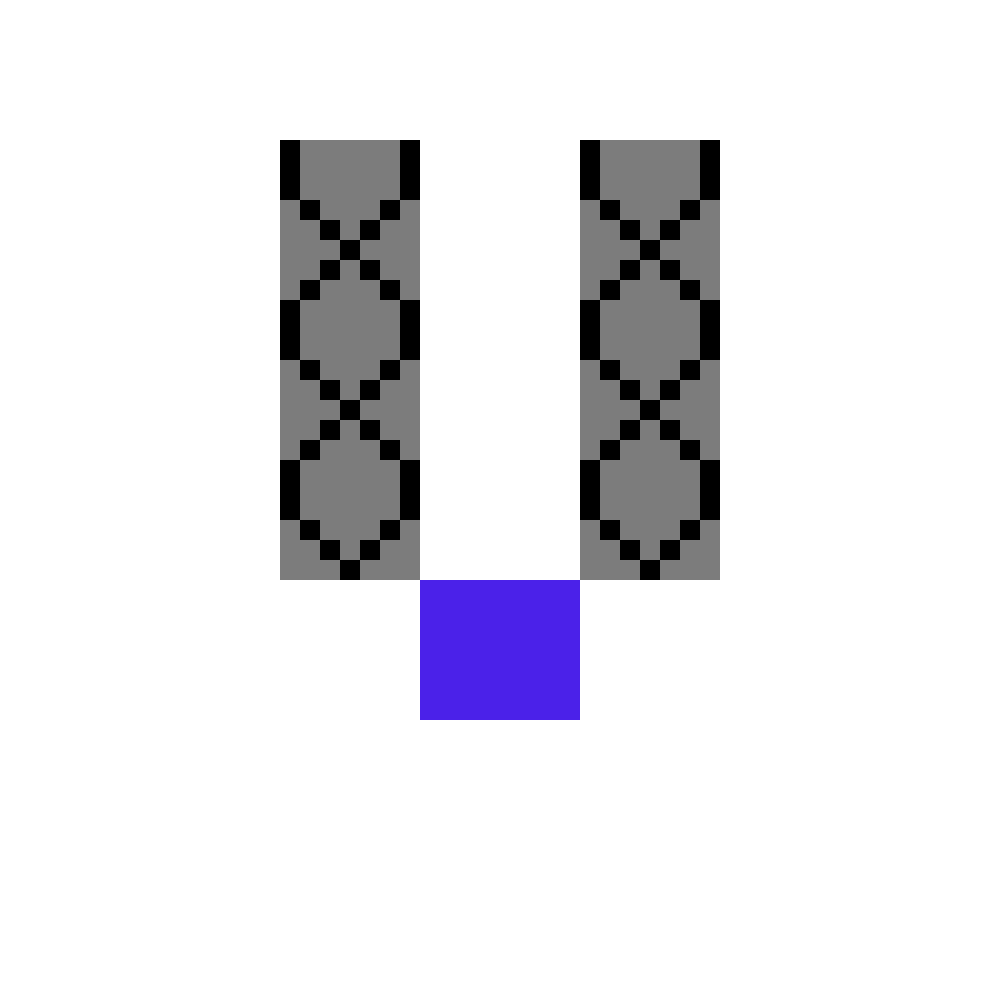
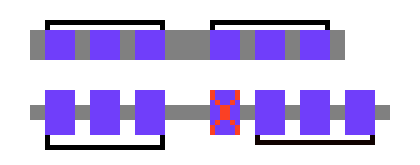

In [88]:
# === CLICK-THROUGH CHROMOSOME → ARM → DNA → MUTATION ===
import requests, io, base64, re
from PIL import Image, ImageDraw
from IPython.display import HTML, display

# --- INPUTS (reuse your existing inputs/vars if you already have them) ---
gene_name  = gene_name  if 'gene_name'  in globals() else input("Enter gene (e.g., NFIX): ")
variant_str = variant_str if 'variant_str' in globals() else input("Enter variant (e.g., c.240A>G): ")

# --- helper: classify mutation string -> choose your drawn image ---
def classify_mutation(mutation_str: str):
    mut = mutation_str.strip().lower()
    if "dup" in mut:
        return "Duplication.png"
    if "fs" in mut or "frameshift" in mut:
        # bias to -del if "del" mentioned; otherwise -ins if "ins" found; else assume -del
        if "ins" in mut: return "Frameshift-ins.png"
        if "del" in mut: return "Frameshift-del.png"
        return "Frameshift-del.png"
    if re.search(r"del", mut) and "fs" not in mut:
        return "Frameshift-del.png"
    if re.search(r"ins", mut) and "fs" not in mut:
        return "Frameshift-ins.png"
    if "*" in mut or "ter" in mut or re.search(r"[a-z]{3}\d+x", mut):
        return "Nonsense.png"
    if ">" in mut or re.search(r"[a-z]{3}\d+[a-z]{3}", mut):
        return "Missense.png"
    # default: just show missense if unknown
    return "Missense.png"

# --- Ensembl: get chromosome + gene start (we'll use start as position proxy) ---
def get_gene_info(gene_symbol):
    xref = f"https://rest.ensembl.org/xrefs/symbol/homo_sapiens/{gene_symbol}?content-type=application/json"
    r = requests.get(xref)
    if not r.ok or not r.json():
        return None, None, None
    ensembl_id = r.json()[0]["id"]

    lookup = f"https://rest.ensembl.org/lookup/id/{ensembl_id}?content-type=application/json"
    lr = requests.get(lookup)
    if not lr.ok or not lr.json():
        return None, None, None
    data = lr.json()
    chrom = data.get("seq_region_name")
    start = data.get("start")
    return chrom, ensembl_id, start

chromosome_num, ensembl_id, variant_start = get_gene_info(gene_name)
if not chromosome_num:
    raise SystemExit("Gene not found in Ensembl (check symbol).")

# --- Get chromosome length (to decide p vs q arm by midpoint) ---
asm = f"https://rest.ensembl.org/info/assembly/homo_sapiens/{chromosome_num}?content-type=application/json"
asm_r = requests.get(asm)
asm_json = asm_r.json()
chromosome_length = asm_json["length"]
arm = "p" if (variant_start is not None and variant_start < (chromosome_length/2)) else "q"

# --- Draw the 23-chromosome grid and box the target chromosome (your layout) ---
img = Image.open("8bitChrom.png").convert("RGBA")

chrom_width = 45
chrom_height = 105
left_margin = 44
top_margin = 43
horizontal_spacing = 30
vertical_spacing = 45
cols_per_row = 8

chrom_coords = {}
cnum = 1
for row in range(3):
    y1 = top_margin + row * (chrom_height + vertical_spacing)
    for col in range(cols_per_row):
        if cnum > 23: break
        x1 = left_margin + col * (chrom_width + horizontal_spacing)
        chrom_coords[str(cnum)] = (x1, y1, x1 + chrom_width, y1 + chrom_height)
        cnum += 1

if str(chromosome_num) in chrom_coords:
    draw = ImageDraw.Draw(img)
    draw.rectangle(chrom_coords[str(chromosome_num)], outline="red", width=6)
else:
    print(f"Chromosome {chromosome_num} not found in grid map.")

# base64 helper
def pil_to_b64(pil_img, fmt="PNG"):
    buf = io.BytesIO()
    pil_img.save(buf, format=fmt)
    return base64.b64encode(buf.getvalue()).decode()

def file_to_b64(path):
    with open(path, "rb") as f:
        return base64.b64encode(f.read()).decode()

chromosome_grid_b64 = pil_to_b64(img)

# --- Sequence of images for the click-through ---
# step 0: 23-chromosome grid (boxed)
step0_b64 = chromosome_grid_b64

# step 1: p/q arm labeled overviews (same for both, just a label image you drew)
step1_b64 = file_to_b64("/Users/ashe/Desktop/Jura/p arm q arm labeled.PNG")

# step 2: correct arm (your stylized “Just p arm” or “Just q arm”)
arm_file = "/Users/ashe/Desktop/Jura/Just p arm.PNG" if arm == "p" else "/Users/ashe/Desktop/Jura/Just q arm.PNG"
step2_b64 = file_to_b64(arm_file)

# step 3: DNA view of that arm
dna_file = f"/Users/ashe/Desktop/Jura/dna {arm} arm.PNG"   # "dna p arm.jpg" or "dna q arm.jpg"
step3_b64 = file_to_b64(dna_file)

# step 4: mutation type image (picked from user input)
mutation_file = f"{classify_mutation(variant_str)}"
step4_b64 = file_to_b64(mutation_file)

# captions for each step
captions = [
    "These are all 23 chromosomes, your variant is located on the highlighted chromosome. Click on the box to learn more",
    "This is a simple diagram explaining the anatomy of a chromosome, there is a p arm (shorter) and q arm (longer).",
    "This is is the arm of the chromosome we will be focusing on",
    "Chromosomes are long strands of DNA tightly packed into structures. We will be focusing on the DNA sequences and the type of variations that can occur.",
    "Example of a frameshift insertion variant looks.",
    "Example of a missense variant looks.",
    "Example of a nonsense variant looks."
]

# --- Build interactive HTML (single <img> that advances on each click) ---
html = f"""
<div style="font-family: ui-sans-serif, system-ui; line-height:1.3; color:#ddd">
  <div style="margin:6px 0 14px 0;">
    <strong>Gene:</strong> {gene_name}
    &nbsp;|&nbsp; <strong>Chr:</strong> {chromosome_num}{arm}
    &nbsp;|&nbsp; <strong>Variant:</strong> {variant_str}
  </div>

  <div style="margin-bottom:8px; opacity:.85">Click the image to step through →</div>

  <img id="walkthrough"
       src="data:image/png;base64,{step0_b64}"
       width="800"
       style="cursor:pointer; border-radius:12px; box-shadow:0 8px 30px rgba(0,0,0,.35);" />

    <div id="caption" style="margin-top:8px; font-size:15px; line-height:1.4;">
    {captions[0]}
</div>

  <div style="margin-top:10px; font-size:12px; opacity:.7">
    Order: 23 chromosomes → p/q labeled → selected arm → DNA arm → mutation type
  </div>
</div>

<script>
(function() {{
  const img = document.getElementById('walkthrough');
  const cap = document.getElementById('caption');

  const frames = [
    "data:image/png;base64,{step0_b64}",
    "data:image/png;base64,{step1_b64}",
    "data:image/png;base64,{step2_b64}",
    "data:image/jpeg;base64,{step3_b64}",
    "data:image/png;base64,{step4_b64}"
  ];

  // Python will render this into a JS array of strings
  const captions = [{", ".join(f"'{c}'" for c in captions)}];

  let idx = 0;

  img.addEventListener('click', () => {{
    idx = Math.min(idx + 1, frames.length - 1);
    img.src = frames[idx];
    cap.textContent = captions[idx];
  }});
}})();
</script>
"""

display(HTML(html))